# Hyperspectral Image autoencoder

1. Import dependencies

In [1]:
import random

import numpy as np
import torch

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split

from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import (
    create_indian_pines_dataset,
    create_patched_indian_pines_dataset,
)
from src.model.autoencoder import (
    SymmetricLinearAutoEncoder,
    SymmetricPointWiseAutoEncoder,
    AsymmetricPointWiseAutoEncoder,
    SpatialAutoEncoder,
)
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.visualization.plot import plot_loss_generic, plot_segmentation_comparison
from src.loss.patch_loss import PatchLoss

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

image_h = 145
image_w = 145
num_classes = 17

# Indian pines

1. Set params

In [3]:
activation = "relu"
epochs = 75

units = [200, 128, 64, 32, 17]

2. Load dataset

In [4]:
_, dataset = create_indian_pines_dataset(device)

In [5]:
train_loader = DataLoader(dataset)

3. Train model

In [ ]:
autoencoder = SymmetricPointWiseAutoEncoder(units).to(device)

In [7]:
autoencoder

SymmetricPointWiseAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(200, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 17, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(17, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 200, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
trainer = AutoEncoderTrainer(
    criterion,
    epochs,
    optimizer,
)

In [ ]:
feedback = trainer.fit(autoencoder, train_loader)

  0%|          | 0/75 [00:00<?, ?it/s]

4. Training results

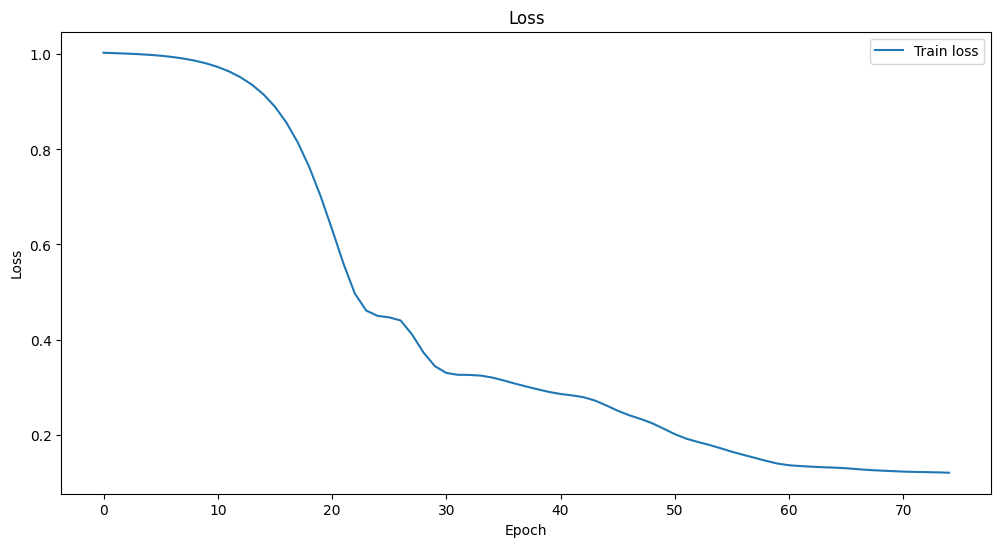

In [10]:
plot_loss_generic([it.train.loss for it in feedback.history], desc="Train loss")

In [11]:
x_test, y_test = dataset[0]

y_test = y_test.squeeze(0).cpu().detach().numpy()

In [12]:
x_test.shape

torch.Size([200, 145, 145])

In [13]:
y_test.shape

(145, 145)

In [14]:
encoded, _ = autoencoder(x_test)

encoded.shape

torch.Size([17, 145, 145])

In [15]:
predicted = np.argmax(encoded.cpu().detach().numpy(), axis=0)

predicted.shape

(145, 145)

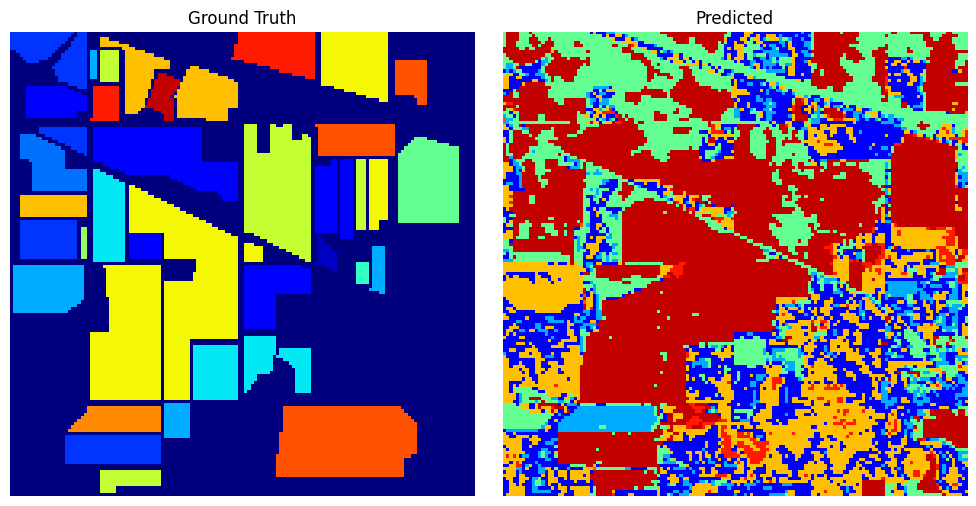

In [16]:
plot_segmentation_comparison(y_test, predicted)

# Indian Pines (Spatial)

1. Set Params

In [17]:
batch_size = 512
epochs = 200

2. Load dataset

In [18]:
_, dataset = create_patched_indian_pines_dataset(device, patch_size=9)

In [19]:
train_dataset, eval_dataset = random_split(dataset, [0.8, 0.2], generator)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

3. Train model

In [21]:
autoencoder = SpatialAutoEncoder(input_channels=200, embedding_size=17).to(device)

In [22]:
autoencoder

SpatialAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(200, 100, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(200, 500, kernel_size=(1, 1), stride=(1, 1))
    (7): Sigmoid()
    (8): Conv2d(500, 17, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Softmax(dim=1)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(17, 500, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(500, 200, kernel_s

In [ ]:
criterion = PatchLoss(nn.MSELoss()).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5)
trainer = AutoEncoderTrainer(
    criterion,
    epochs,
    optimizer,
)

In [ ]:
feedback = trainer.fit(autoencoder, train_loader, eval_loader)

  0%|          | 0/200 [00:00<?, ?it/s]

4. Train results

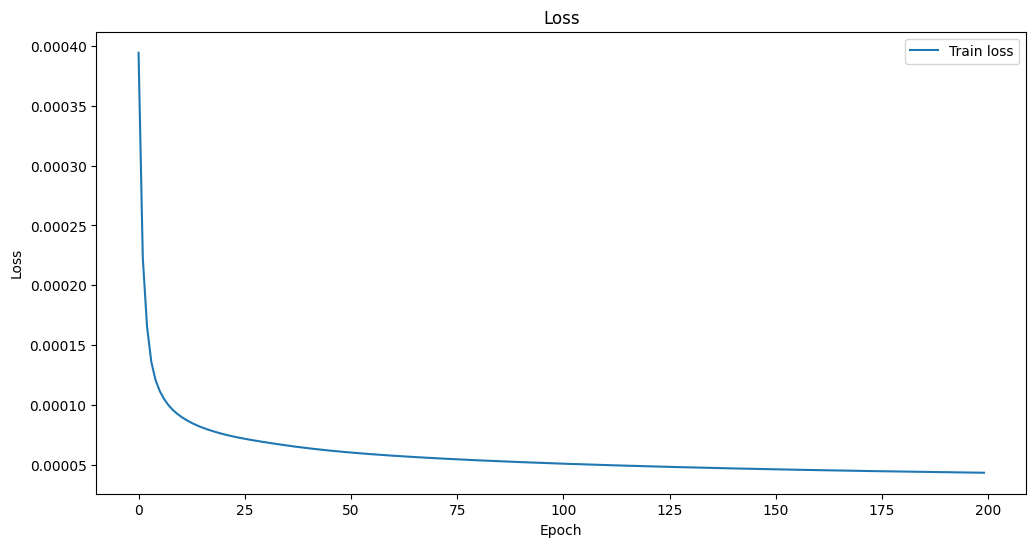

In [25]:
plot_loss_generic([it.train.loss for it in feedback.history], desc="Train loss")

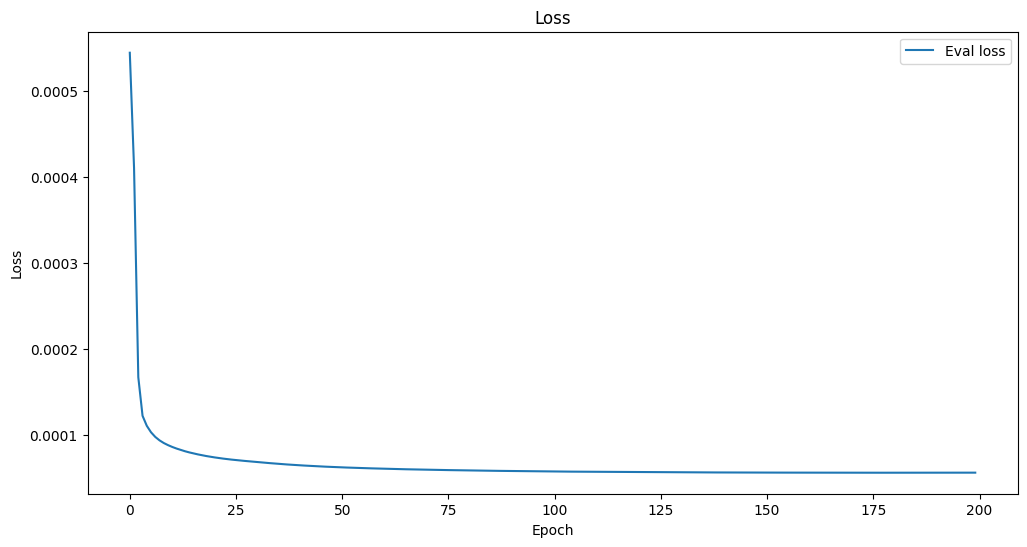

In [26]:
plot_loss_generic([it.eval.loss for it in feedback.history], desc="Eval loss")

In [27]:
x_test, y_test = dataset[:]

In [28]:
y_test = y_test.reshape(image_h, image_w)

In [29]:
x_test.shape

torch.Size([21025, 200, 9, 9])

In [30]:
y_test.shape

torch.Size([145, 145])

In [31]:
y_pred, _ = autoencoder(x_test)

In [32]:
y_pred = torch.argmax(y_pred.reshape(image_h, image_w, num_classes), dim=2)

In [33]:
y_pred.shape

torch.Size([145, 145])

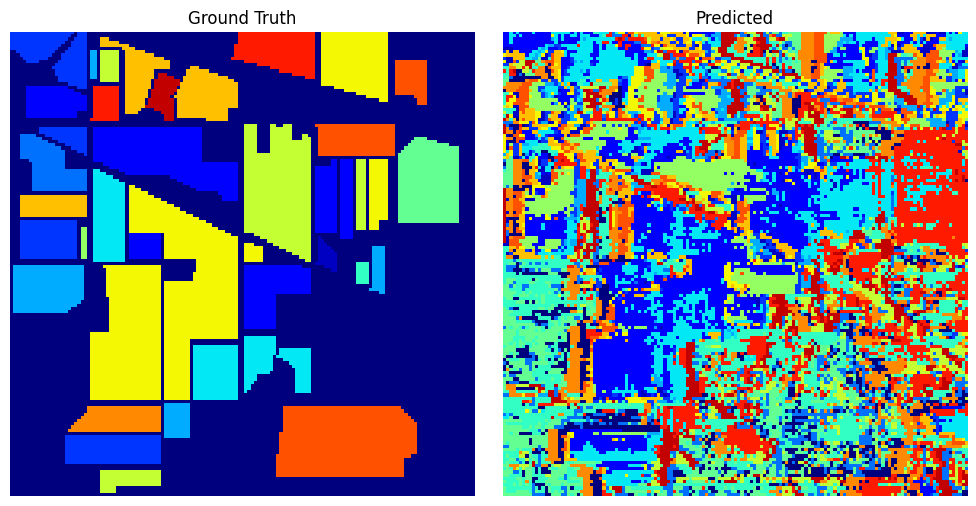

In [34]:
plot_segmentation_comparison(y_test.cpu(), y_pred.cpu())